## Image based attendence capturing system using deep learning and computer vision

In [ ]:
# Steps Done
# 1. Rearranged the data in the trainset folder and created two folder train_01,test_01
# 2. imported that dataset in this notebook as tensor
# 3. Created a Deep CNN model from scratch
# 4. Trained the modeland applied it to test set 
# 5. Created a model which will accept the image and compare the image with the ones in the train set and gives 
#    an output matched or not matched



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Importing all the dataset from directory to the notebook
def test_train_data():
    # data_dir = 'C:\\Users\\16124\\Documents\\Rishika\\Internship work\\trainset'
    
    transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), 
                                                                                                                                 --(0.5, 0.5, 0.5))])
    
    train_set = datasets.ImageFolder( '/content/drive/MyDrive/Program/train_01', transform =transform )
    test_set = datasets.ImageFolder( '/content/drive/MyDrive/Program/test_01', transform =transform)
    
    train = DataLoader(train_set, batch_size=1, shuffle=True)
    test = DataLoader(test_set, batch_size=1, shuffle=True)
    return train,test

#Printing few images to check the training set
def train_imshow():
    dataiter = iter(train)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))
    plt.imshow()

In [106]:
#Assigning variable names for the test and training data sets
train,test = test_train_data() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

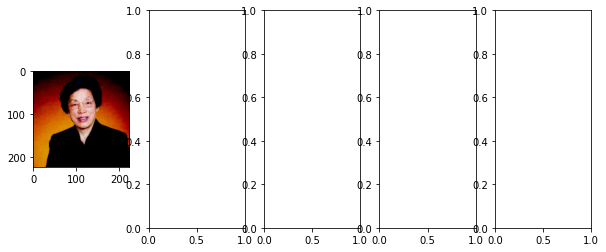

In [ ]:
train_imshow()

In [41]:
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unit, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=3, out_channels=out_channels, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output
    
    
class SimpleNet(nn.Module):
    def __init__(self,num_classes=1012):
        super(SimpleNet,self).__init__()
        
        #Creating 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Adding all the units into the Sequential layer in the exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)

        self.fc = nn.Linear(in_features=128*7*7,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128*7*7)
        output = self.fc(output)
        return output

In [42]:
model = SimpleNet()

In [43]:
net = SimpleNet()

In [255]:
# Checking to see if gpu support is available
cuda_avail = torch.cuda.is_available()
print("true")
# Creating model, optimizer and loss function
model = SimpleNet(num_classes=1012)

#if cuda is available, moving the model to the GPU (which is not happening in my system)
if cuda_avail:
    model.cuda()
    net.cuda()
    print("done")
#Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

true
done


In [45]:
# Creating a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):
    lr = 0.001

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 120:
        lr = lr / 10000
    elif epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [46]:
# A  callable function to save the trained model
def save_models(epoch):
    PATH = '/content/drive/MyDrive/Program/new_model.pth'
    torch.save(model.state_dict(),PATH.format(epoch))
    print("Checkpoint saved")


In [113]:
# A callable function which will evaluate trained model on the test data
def test_model():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test):

        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Predicting classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        test_acc += torch.sum(prediction == labels.data)

    # Computing the average acc and loss over all the test images
    test_acc = test_acc / len(test)

    return test_acc

In [185]:
def train_model(num_epochs):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train):
          # Moving images and labels to gpu if available
          images = Variable(images.cuda())
          labels = Variable(labels.cuda())

          # Clearing all accumulated gradients
          optimizer.zero_grad()

          # Predicting classes using images from the test set
          outputs = model(images)

          # Computing the loss based on the predictions and actual labels
          loss = loss_fn(outputs, labels)

          # Backpropagating the loss
          loss.backward()

          # Adjusting parameters according to the calculated gradients
          optimizer.step()
          train_loss += loss.item()* images.size(0)
          _, prediction = torch.max(outputs.data, 1)
          train_acc += torch.sum(prediction == labels.data)

        # Calling the learning rate adjustment function
        adjust_learning_rate(epoch)

        # Computing the average acc and loss over all training images
        train_acc = train_acc / len(train)
        train_loss = train_loss / len(train)

        # Evaluating on the test set
        test_acc = test_model()

        # Saving the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc

        # Printing the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))

In [ ]:
train_model(200) 

## Inference with the Saved Model

In [187]:
# Steps done here are as follows:
# 1. Loading our saved model 
# 2. Creating a function called predict_image which will read the image in the PIL format and convert it into 
#    tensor format so that further comparasion can be done
# 3. Another function called train_pred is used to compare the returned index from test data witht hte trained data
#    and give an output matched or not matched
# 4. In the last step we predict the confidence score of the prediction 
# Us as a user just have to provide the path for the test image

In [188]:
#Loading the saved model
path = '/content/drive/MyDrive/Program/new_model.pth'
checkpoint = torch.load(path)
model = SimpleNet(num_classes=1012)


model.load_state_dict(checkpoint)
model.eval()

SimpleNet(
  (unit1): Unit(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit2): Unit(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit3): Unit(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit4): Unit(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit5): Unit(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [281]:
# Reads and converts the images from PIL format image to tensor format and returns an index value which will be 
# compared with train data later
from PIL import Image
from torch.autograd import Variable
import torchvision
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
  

    # Turn the input into a Variable
    input = Variable(image_tensor)
    input = input.to(device)
#     print('input',input)
    # Predict the class of the image
    input.cuda()
    output = net(input)
    index = output.data.cpu().numpy().argmax()
    
    
    # Displaying the test image
    plt.imshow(image)
    
    return index






In [282]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [283]:
# This callable function takes the test data index and compares it with the trained set and compares the 
# information and displays a match or no match
def train_pred(index):
    count = 0
    for data in train:
        images,labels = data

        if labels == index:
            print("output matched",labels)
          
        else:
            count += 1

Prediction in progress


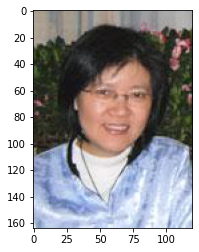

In [286]:
# User can put the directory of the image to be tested in the variable image_path and run the cell
image_path = "/content/drive/MyDrive/Program/train_01/0005_0000530/0005_0000530_script.jpg"
index = predict_image(image_path)

In [288]:
# Calling the function for comparison
train_pred(index)

output matched tensor([857])


In [295]:
#Accuracy prediction
r = 0
s = 0
with torch.no_grad():
    for data in test:
        images,test_label = data
        r += test_label.size(0)
        for info in train:
            images,train_label =info
            if train_label == test_label:
                s += (train_label == test_label).sum().item()
 
print('Accuracy of a network is: %d %% ' % (100*r/s))
            

Accuracy of a network is: 73 % 
